# 라이브러리 불러오기

In [2]:
import argparse 
import os
import torch
import torchaudio
import numpy as np
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from wav2vec2_vib import Model
from torchinfo import summary
import librosa

/home/woonj/anaconda3/envs/grad_cam/lib/python3.9/site-packages/pytorch_grad_cam/utils/image.py:10: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.ndimage import zoom


# 모델 불러오기

In [3]:
# device = "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = Model(
    device=device,
    ssl_cpkt_path='xlsr2_300m.pt', # https://github.com/facebookresearch/fairseq/blob/main/examples/wav2vec/xlsr/README.md#:~:text=XLS%2DR%20300M-,download,-XLS%2DR%201B
).to(device)
# 가중치 로드 시 에러 핸들링 추가
try:
    model.load_state_dict(torch.load('vib_conf-5_gelu_2s_may27_epoch6.pth', map_location=device))
    print("Model weights loaded successfully!")
except FileNotFoundError:
    print("Model weights file not found. Please check the file path.")
except Exception as e:
    print(f"Error loading model weights: {e}")

/home/woonj/anaconda3/envs/grad_cam/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model weights loaded successfully!


In [4]:
# 오디오 로드
# audio_path = "/home/woonj/grad-cam/1조인성_수상소감.wav"
audio_path = "/home/woonj/grad-cam/CON_E_0033629.wav"
# audio_path = "/home/woonj/LIME_audio/audio_sample/송혜교_수상소감.mp3"

# 필요한 경우 샘플링 레이트 설정 (None으로 기본 샘플링 레이트 사용)
# waveform, sr = librosa.load(audio_path, sr=16000)  # librosa를 사용한다면 이렇게 가능
waveform = torch.randn(64000)
waveform =  torch.Tensor(waveform)
waveform = waveform.unsqueeze(0)
waveform.shape

torch.Size([1, 64000])

In [5]:
model

Model(
  (ssl_model): SSLModel(
    (model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU(approximate='none')
          )
          (1-4): 4 x Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU(approximate='none')
          )
          (5-6): 2 x Sequential(
            (0): Conv1d(512, 512, kernel_size=

# Grad-CAM 적용하기

In [5]:
# target_layer = model.LL
# activation_layer = [model.ssl_model.model.feature_extractor.conv_layers[-1][0]]
# gradient_layers = model.backend.m_utt_level
# target_layer = [model.ssl_model.model.feature_extractor.conv_layers[-1][0]]
# target_layer = model.ssl_model.model.encoder.layers[23].self_attn.out_proj
target_layer = model.backend.m_frame_level[6]

call function
forward
torch.Size([1, 64000])
activations_and_gradients - call
torch.Size([1, 64000])
Input tensor shape: torch.Size([1, 1, 64000])
Input tensor shape: torch.Size([1, 512, 12799])
Input tensor shape: torch.Size([1, 512, 6399])
Input tensor shape: torch.Size([1, 512, 3199])
Input tensor shape: torch.Size([1, 512, 1599])
Input tensor shape: torch.Size([1, 512, 799])
Input tensor shape: torch.Size([1, 512, 399])
Input tensor shape: torch.Size([1, 1024, 199])
target
target_categories :  [1]
targets :  [<pytorch_grad_cam.utils.model_targets.ClassifierOutputTarget object at 0x7efd23891130>]
compute_cam_per_layer
input_tensor_basecam :  torch.Size([1, 64000])
grads [[[6.9680071e-04 6.8741065e-04 9.3056832e-04 ... 5.2312278e-04
   8.6601899e-04 4.3515392e-05]
  [7.0478016e-04 6.8444997e-04 9.3936059e-04 ... 5.2699225e-04
   8.5752679e-04 4.9739676e-05]
  [6.5698207e-04 6.8270561e-04 9.1907656e-04 ... 5.2814867e-04
   8.8142947e-04 5.4490767e-05]
  ...
  [7.0061313e-04 6.8553898e

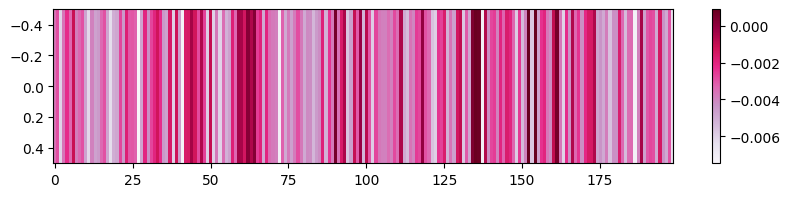

scale_cam_image


In [6]:
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=waveform, targets=None)

In [7]:
grayscale_cam.shape

(1, 1185)

In [6]:
grayscale_cam

array([[0.24130741, 0.38811323, 0.2164352 , 0.26732653, 0.32581896,
        0.2827248 , 0.24325219, 0.31258446, 0.39113474, 0.27718765,
        0.29744446, 0.2539569 , 0.1920264 , 0.32705778, 0.21826188,
        0.2121109 , 0.36403883, 0.2397961 , 0.19867274, 0.44594195,
        0.21817918, 0.20413971, 0.17438233, 0.21897978, 0.23161046,
        0.2808455 , 0.12128152, 0.17702499, 0.09228221, 0.19021732,
        0.391454  , 0.19079491, 0.        , 0.24873649, 0.61472046,
        0.9034162 , 0.47881708, 0.17325369, 0.28336817, 0.23875344,
        0.05034167, 0.8575715 , 0.9158704 , 0.9705464 , 0.3989373 ,
        0.2255633 , 0.9142306 , 0.30343053, 0.3336493 , 0.97991693,
        0.9259459 , 1.        , 0.9528429 , 0.9430947 , 0.915661  ,
        0.20468795, 0.32274163, 0.24861374, 0.32802472, 0.3033283 ,
        0.20870762, 0.20212312, 0.33111125, 0.32025826, 0.32321244,
        0.07485427, 0.31018388, 0.27723402, 0.36638114, 0.42442387,
        0.48998818, 0.15353477, 0.41161725, 0.35

# 시각화

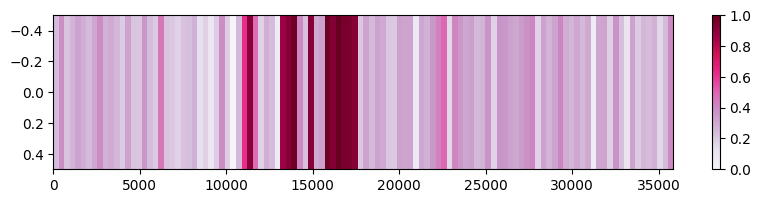

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `normalized_tensor` is the tensor you've normalized and is now in the range [0, 1]
# Scale the tensor to have a maximum of 320
# scaled_tensor_np = grayscale_cam.detach().numpy()
# Set the number of pixels for each value
pixel_per_value = 320

# Create a new array with expanded width
expanded_heatmap = np.repeat(grayscale_cam, pixel_per_value, axis=1)

# Create the heatmap
plt.figure(figsize=(10, 2))  # Set the size of the heatmap
plt.imshow(expanded_heatmap, cmap='PuRd', interpolation='nearest', aspect='auto')  # Generate the heatmap
plt.colorbar()  # Add color bar
plt.show()

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

# Load your audio file (this can be changed based on your audio data loading)
waveform, sr = librosa.load(audio_path, sr=16000)

# Example Grad-CAM scores for each frame (replace this with your actual Grad-CAM results)
# Assuming the length of the Grad-CAM scores corresponds to the number of frames
grad_cam_scores = np.random.rand(100)  # Replace with actual Grad-CAM scores

# Plotting the waveform
plt.figure(figsize=(10, 6))

# First subplot: waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(waveform, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Second subplot: Grad-CAM heatmap
plt.subplot(2, 1, 2)

# Create a heatmap where each score corresponds to a colored rectangle
# Normalize the Grad-CAM scores between 0 and 1
grad_cam_scores_normalized = (grad_cam_scores - np.min(grad_cam_scores)) / (np.max(grad_cam_scores) - np.min(grad_cam_scores))

# Create a heatmap based on Grad-CAM scores (for this example, assume 100 frames)
time_steps = np.linspace(0, len(waveform)/sr, len(grad_cam_scores))

plt.imshow(grad_cam_scores_normalized[np.newaxis, :], cmap='Rimport matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

# 예제 waveform 데이터를 생성 (실제로는 여러분의 오디오 데이터를 사용)
waveform, sr = librosa.load('path_to_your_audio.wav', sr=None)

# Grad-CAM 데이터를 기반으로 그린 히트맵 (여러분의 grayscale_cam 데이터를 사용)
grayscale_cam = np.random.rand(1, 100)  # 여기를 실제 Grad-CAM 값으로 대체

# 각 Grad-CAM 값을 몇 픽셀로 표현할지 결정 (가로 길이 확장)
pixel_per_value = 320  # 각 값이 320개의 픽셀로 표현됨
expanded_heatmap = np.repeat(grayscale_cam, pixel_per_value, axis=1)

# Figure 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})

# 1. 웨이브폼을 그립니다.
librosa.display.waveshow(waveform, sr=sr, ax=ax1)
ax1.set_title('Waveform')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# 2. Grad-CAM 히트맵을 웨이브폼 아래에 그립니다.
ax2.imshow(expanded_heatmap, cmap='PuRd', interpolation='nearest', aspect='auto')
ax2.set_title('Grad-CAM Scores')
ax2.set_xlabel('Time (s)')
ax2.set_yticks([])  # y축은 필요 없으므로 제거

# 그래프 간의 간격 조정
plt.tight_layout()
plt.show()
eds', aspect='auto', extent=[0, len(waveform)/sr, 0, 1])
plt.yticks([])
plt.xlabel('Time (s)')
plt.title('Grad-CAM Scores')

plt.tight_layout()
plt.show()


SyntaxError: EOL while scanning string literal (3504469727.py, line 33)

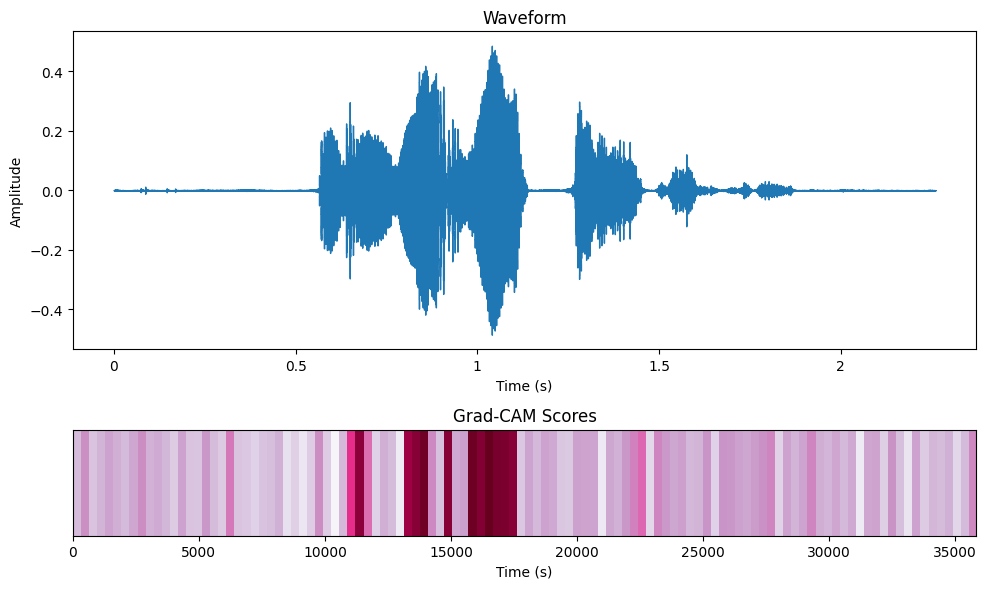

In [8]:
from IPython.display import Audio  # 오디오 재생을 위한 모듈
import matplotlib.pyplot as plt
import librosa.display

# 예제 waveform 데이터를 생성 (실제로는 여러분의 오디오 데이터를 사용)
waveform, sr = librosa.load(audio_path, sr=None)

# 각 Grad-CAM 값을 몇 픽셀로 표현할지 결정 (가로 길이 확장)
pixel_per_value = 320  # 각 값이 320개의 픽셀로 표현됨
expanded_heatmap = np.repeat(grayscale_cam, pixel_per_value, axis=1)

# Figure 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})

# 1. 웨이브폼을 그립니다.
librosa.display.waveshow(waveform, sr=sr, ax=ax1)
ax1.set_title('Waveform')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# 2. Grad-CAM 히트맵을 웨이브폼 아래에 그립니다.
ax2.imshow(expanded_heatmap, cmap='PuRd', interpolation='nearest', aspect='auto')
ax2.set_title('Grad-CAM Scores')
ax2.set_xlabel('Time (s)')
ax2.set_yticks([])  # y축은 필요 없으므로 제거

# 그래프 간의 간격 조정
plt.tight_layout()
plt.show()
# 오디오 재생 기능 추가 (HTML5 재생바로 오디오 재생)
audio_widget = Audio(waveform, rate=sr)
display(audio_widget)

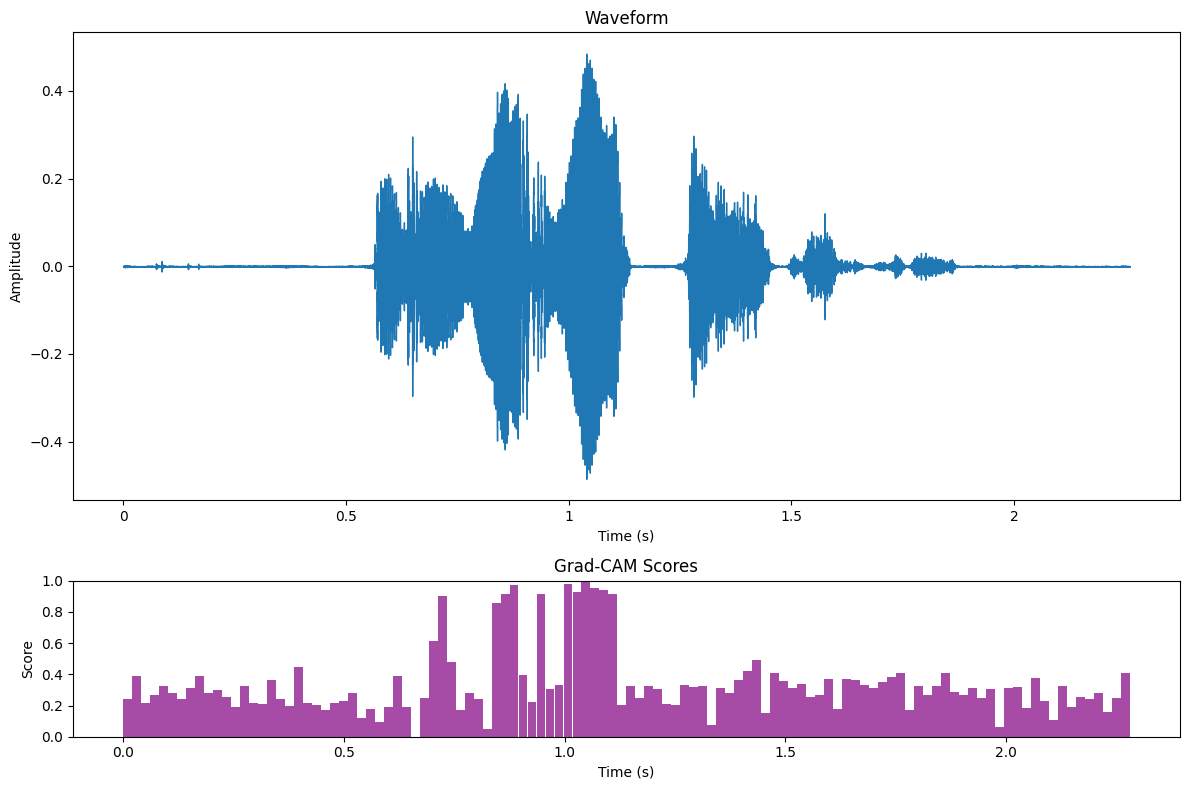

In [10]:
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Load the audio file
waveform, sr = librosa.load(audio_path, sr=None)

# Get Grad-CAM values
grad_cam_values = grayscale_cam.squeeze()  # Remove any extra dimensions

# Calculate frame times
num_frames = len(grad_cam_values)
duration = len(waveform) / sr
frame_times = np.linspace(0, duration, num_frames)

# Create the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot the waveform
librosa.display.waveshow(waveform, sr=sr, ax=ax1)
ax1.set_title('Waveform')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot Grad-CAM scores as a bar chart
ax2.bar(frame_times, grad_cam_values, width=duration/num_frames, align='edge', color='purple', alpha=0.7)
ax2.set_title('Grad-CAM Scores')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1)  # Assuming Grad-CAM scores are normalized between 0 and 1

# Adjust layout and display
plt.tight_layout()
plt.show()

# Display audio player
audio_widget = Audio(waveform, rate=sr)
display(audio_widget)